In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# We can define Milstein as follows (Proposition 4.6.6), as sigma is 1 dimensional, hence verifies Milstein approximation
def Milstein1D(T, xi, mu, sigma, sigma_P, W):
    N, M = W.shape[0], W.shape[1]
    N -= 1
    milstein_Y = np.zeros(M)
        
    for i in range(M):
        Y_n = xi
        for n in range(N):
            aux_1 = mu(Y_n) * T/N
            aux_2 = sigma(Y_n) * (W[n+1][i] - W[n][i])
            aux_3 = T / (2*N) * sigma_P(Y_n) * sigma(Y_n)
            aux_4 = 1 / 2 * sigma_P(Y_n) * sigma(Y_n) * (W[n+1][i] - W[n][i]) ** 2

            Y_n += aux_1 + aux_2 - aux_3 + aux_4

        milstein_Y[i] = Y_n

    return milstein_Y


In [5]:
def mu(x):
    return x

def sigma(x):
    return 1 + np.log(x**2)

def sigma_prime(x):
    return 2/x

Strong rate of convergence in L^1: 0.9858749336017999
Strong rate of convergence in L^2: 0.9978903479292046


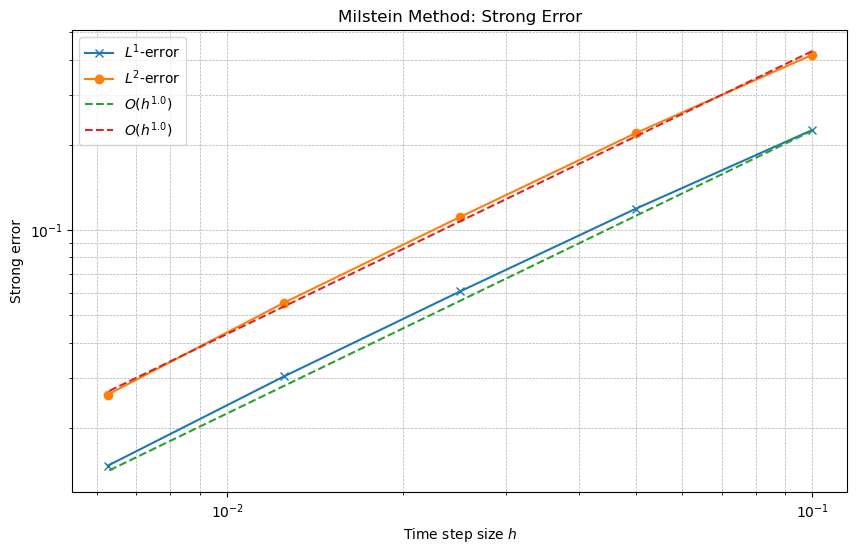

In [7]:
# Parameters
N0 = 10  # number of steps on the coarsest level
L = 4    # number of refinement steps
extra = 3  # extra levels of refinement for overkill solution
M = int(1e5)  # number of samples
T = 1.0  # final time
xi = 1.0  # initial value of the SDE

L_ok = L + extra
N_ok = N0 * 2**L_ok

# Set random seed for reproducibility
np.random.seed(12345)

# Path of Brownian motions on the finest level
# Generate Brownian paths
dt_ok = T / N_ok
W_ok = np.sqrt(dt_ok) * np.random.randn(M, N_ok)

# Values of S_T for h=T/(N*2^l), l=0,...,L,L_ok
Lv = list(range(0, L + 1)) + [L_ok]
ST = np.zeros((len(Lv), M))

# Loop over levels
for l_index, l in enumerate(Lv):
    N = N0 * 2**l
    dt = T / N
    W = np.sum(W_ok.reshape(M, -1, 2**(L_ok - l)), axis=2)  # Downsample Brownian motion

    # Milstein method for SDE
    X = np.full(M, xi)
    for i in range(N):
        dW = W[:, i]
        X = X + mu(X) * dt + sigma(X) * dW + 0.5 * sigma(X) * sigma_prime(X) * (dW**2 - dt)
    
    ST[l_index, :] = X

# (ii) Strong L^p convergence
# Errors for ST compared to overkill solution
STerr = np.abs(ST[:-1, :] - ST[-1, :])
STerr1 = np.mean(STerr, axis=1)  # Mean errors for strong L^1 convergence
STerr2 = np.sqrt(np.mean(STerr**2, axis=1))  # Mean square errors for strong L^2 convergence

# Vector of time step sizes
hv = T / (N0 * 2**np.arange(L + 1))

# Compute convergence rates
r1 = np.polyfit(np.log(hv), np.log(STerr1), 1)
print(f'Strong rate of convergence in L^1: {r1[0]}')

r2 = np.polyfit(np.log(hv), np.log(STerr2), 1)
print(f'Strong rate of convergence in L^2: {r2[0]}')

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(hv, STerr1, '-x', label='$L^1$-error')
plt.loglog(hv, STerr2, '-o', label='$L^2$-error')
plt.loglog(hv, np.exp(r1[1]) * hv, '--', label=f'$O(h^{{{r1[0]:.1f}}})$')
plt.loglog(hv, np.exp(r2[1]) * hv, '--', label=f'$O(h^{{{r2[0]:.1f}}})$')

plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xlabel('Time step size $h$')
plt.ylabel('Strong error')
plt.title('Milstein Method: Strong Error')
plt.show()